In [1]:
import numpy as np
import nibabel as nib
import glob
import random
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
TRAIN_DATASET_PATH = "C:\BraTS\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"

test_image_flair=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355\BraTS20_Training_355_flair.nii').get_fdata()
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

test_image_t1=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355\BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355\BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355\BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + '\BraTS20_Training_355\BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

[0 1 2 4]
[0 1 2 3]


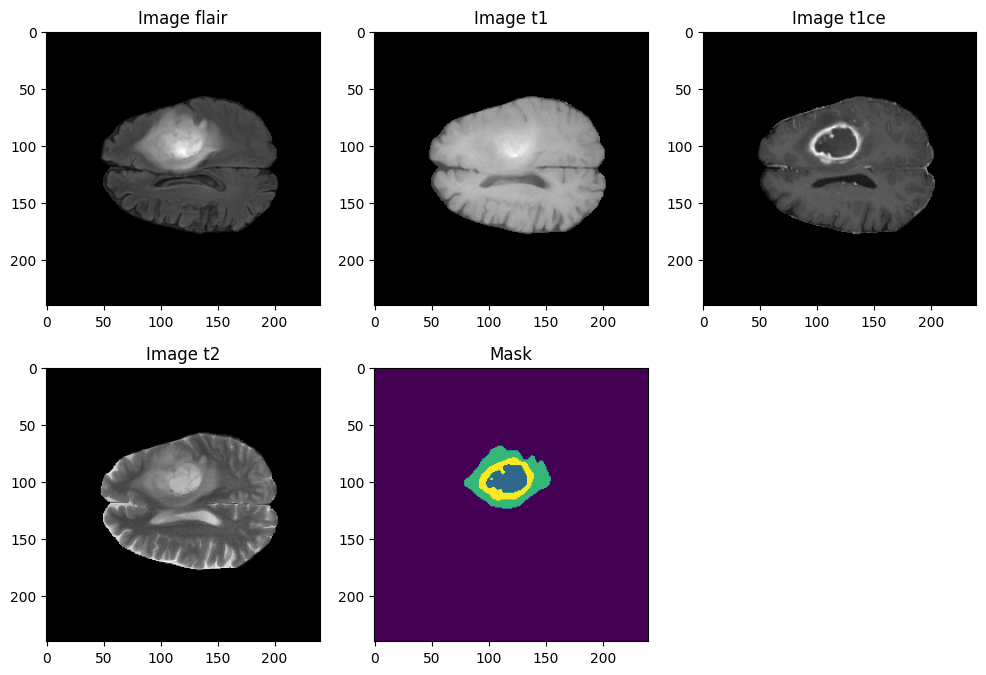

In [4]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(2,3,1)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(2,3,2)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(2,3,3)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(2,3,4)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(2,3,5)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [22]:
##################################################
#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

# #End of understanding the dataset. Now get it organized.
# #####################################

In [24]:
#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

#Keras datagenerator does ntot support 3d

# # # images lists harley
t2_list = sorted(glob.glob('C:\BraTS\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\*\*t2.nii'))
t1ce_list = sorted(glob.glob('C:\BraTS\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\*\*t1ce.nii'))
flair_list = sorted(glob.glob('C:\BraTS\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\*\*flair.nii'))
mask_list = sorted(glob.glob('C:\BraTS\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\*\*seg.nii'))

#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes

for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('C:\BraTS\BraTS2020_TrainingData\input_data_3channels\images\image_'+str(img)+'.npy', temp_combined_images)
        np.save('C:\BraTS\BraTS2020_TrainingData\input_data_3channels\masks\mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")   

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me
Now p

Save Me
Now preparing image and masks number:  162
Save Me
Now preparing image and masks number:  163
Save Me
Now preparing image and masks number:  164
Save Me
Now preparing image and masks number:  165
Save Me
Now preparing image and masks number:  166
Save Me
Now preparing image and masks number:  167
Save Me
Now preparing image and masks number:  168
Save Me
Now preparing image and masks number:  169
Save Me
Now preparing image and masks number:  170
Save Me
Now preparing image and masks number:  171
Save Me
Now preparing image and masks number:  172
Save Me
Now preparing image and masks number:  173
Save Me
Now preparing image and masks number:  174
Save Me
Now preparing image and masks number:  175
Save Me
Now preparing image and masks number:  176
I am useless
Now preparing image and masks number:  177
Save Me
Now preparing image and masks number:  178
Save Me
Now preparing image and masks number:  179
Save Me
Now preparing image and masks number:  180
Save Me
Now preparing imag

Save Me
Now preparing image and masks number:  322
Save Me
Now preparing image and masks number:  323
Save Me
Now preparing image and masks number:  324
I am useless
Now preparing image and masks number:  325
Save Me
Now preparing image and masks number:  326
Save Me
Now preparing image and masks number:  327
Save Me
Now preparing image and masks number:  328
Save Me
Now preparing image and masks number:  329
Save Me
Now preparing image and masks number:  330
Save Me
Now preparing image and masks number:  331
Save Me
Now preparing image and masks number:  332
Save Me
Now preparing image and masks number:  333
Save Me
Now preparing image and masks number:  334
Save Me
Now preparing image and masks number:  335
Save Me
Now preparing image and masks number:  336
Save Me
Now preparing image and masks number:  337
Save Me
Now preparing image and masks number:  338
Save Me
Now preparing image and masks number:  339
Save Me
Now preparing image and masks number:  340
I am useless
Now preparing

In [33]:
#Repeat the same from above for validation data folder
t2_list = sorted(glob.glob('C:\BraTS\BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData\*\*t2.nii'))
t1ce_list = sorted(glob.glob('C:\BraTS\BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData\*\*t1ce.nii'))
flair_list = sorted(glob.glob('C:\BraTS\BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData\*\*flair.nii'))

#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes

for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    #temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    print("Save Me")
    np.save(r"C:\BraTS\BraTS2020_ValidationData\validation_data_3channels\images\image_"+str(img)+'.npy', temp_combined_images)
#     val, counts = np.unique(temp_mask, return_counts=True)
    
#     if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
#         print("Save Me")
#         #temp_mask= to_categorical(temp_mask, num_classes=4)
#         np.save('C:\BraTS\BraTS2020_ValidationData\validation_data_3channels\images\image_'+str(img)+'.npy', temp_combined_images)
#         #np.save('C:\BraTS\BraTS2020_ValidationData\validation_data_3channels\masks\mask_'+str(img)+'.npy', temp_mask)
        
#     else:
#         print("I am useless")   

Now preparing image number:  0
Save Me
Now preparing image number:  1
Save Me
Now preparing image number:  2
Save Me
Now preparing image number:  3
Save Me
Now preparing image number:  4
Save Me
Now preparing image number:  5
Save Me
Now preparing image number:  6
Save Me
Now preparing image number:  7
Save Me
Now preparing image number:  8
Save Me
Now preparing image number:  9
Save Me
Now preparing image number:  10
Save Me
Now preparing image number:  11
Save Me
Now preparing image number:  12
Save Me
Now preparing image number:  13
Save Me
Now preparing image number:  14
Save Me
Now preparing image number:  15
Save Me
Now preparing image number:  16
Save Me
Now preparing image number:  17
Save Me
Now preparing image number:  18
Save Me
Now preparing image number:  19
Save Me
Now preparing image number:  20
Save Me
Now preparing image number:  21
Save Me
Now preparing image number:  22
Save Me
Now preparing image number:  23
Save Me
Now preparing image number:  24
Save Me
Now prepar

In [2]:
import splitfolders  # or import split_folders

input_folder = 'C:\BraTS\BraTS2020_TrainingData\input_data_3channels/'
output_folder = 'C:\BraTS\BraTS2020_TrainingData\input_data_128/'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) 

Copying files: 688 files [02:38,  4.33 files/s]


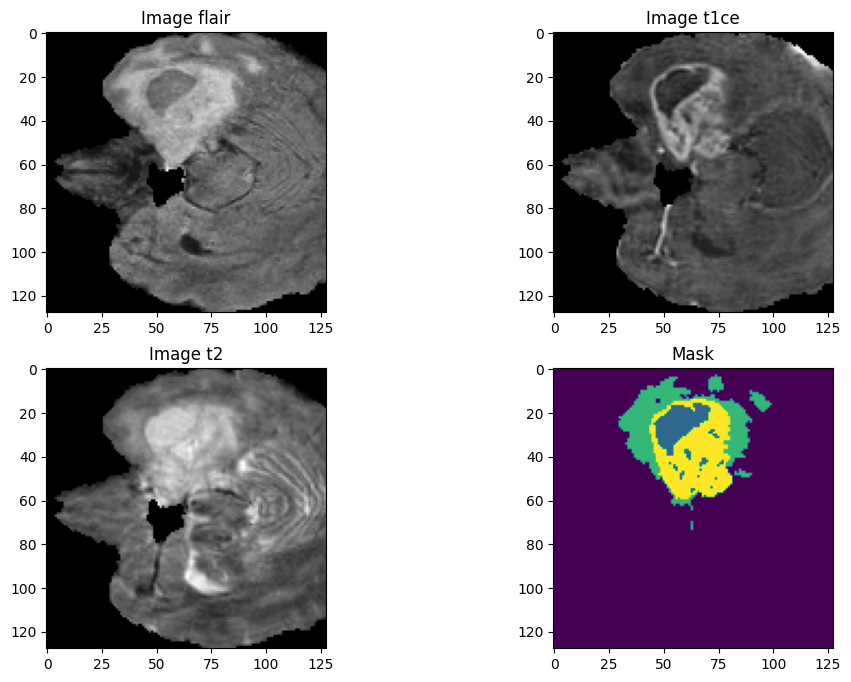

In [4]:
"""
Custom data generator to work with BraTS2020 dataset.
No image processing operations are performed here, just load data from local directory
in batches. 
"""

#from tifffile import imsave, imread
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

############################################

#Test the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "C:\BraTS\BraTS2020_TrainingData\input_data_128/train/images/"
train_mask_dir = "C:\BraTS\BraTS2020_TrainingData\input_data_128/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [5]:
##############################################################
#Define the image generators for training and validation
import os
train_img_dir = "C:\BraTS\BraTS2020_TrainingData\input_data_128/train_less/images/"
train_mask_dir = "C:\BraTS\BraTS2020_TrainingData\input_data_128/train_less/masks/"

val_img_dir = "C:\BraTS\BraTS2020_TrainingData\input_data_128/val_less/images/"
val_mask_dir = "C:\BraTS\BraTS2020_TrainingData\input_data_128/val_less/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
##################################

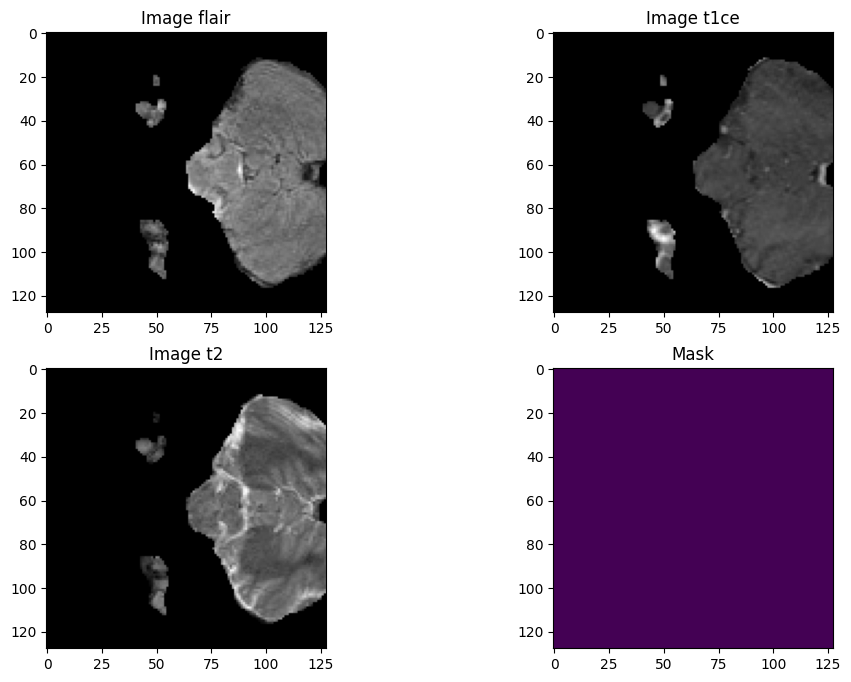

In [6]:
########################################################################
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [8]:
#Fit the model 
# from 3d_unet import simple_unet_model
import nbimporter
import keras

wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

from model_3d_unet import simple_unet_model

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

LR = 0.0001
optim = keras.optimizers.Adam(LR)

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_38 (Conv3D)             (None, 128, 128, 12  1312        ['input_3[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 128, 12  0           ['conv3d_38[0][0]']              
                                8, 16)                                                      

                                                                                                  
 conv3d_50 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_9[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_24 (Dropout)           (None, 32, 32, 32,   0           ['conv3d_50[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_51 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_24[0][0]']             
                                64)                                                               
                                                                                                  
 conv3d_tr

                                64)                                                               
                                                                                                  
 max_pooling3d_10 (MaxPooling3D  (None, 16, 16, 16,   0          ['conv3d_43[0][0]']              
 )                              64)                                                               
                                                                                                  
 conv3d_44 (Conv3D)             (None, 16, 16, 16,   221312      ['max_pooling3d_10[0][0]']       
                                128)                                                              
                                                                                                  
 dropout_21 (Dropout)           (None, 16, 16, 16,   0           ['conv3d_44[0][0]']              
                                128)                                                              
          

 conv3d_55 (Conv3D)             (None, 128, 128, 12  6928        ['dropout_26[0][0]']             
                                8, 16)                                                            
                                                                                                  
 conv3d_56 (Conv3D)             (None, 128, 128, 12  68          ['conv3d_55[0][0]']              
                                8, 4)                                                             
                                                                                                  
Total params: 5,645,828
Trainable params: 5,645,828
Non-trainable params: 0
__________________________________________________________________________________________________
None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('brats_3d.hdf5')
# ##################################################################


# #plot the training and validation IoU and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
# #################################################
#from keras.models import load_model

# #Load model for prediction or continue training

# #For continuing training....
# #The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
# #This is because the model does not save loss function and metrics. So to compile and 
# #continue training we need to provide these as custom_objects.
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5')

# #So let us add the loss as custom object... but the following throws another error...
# #Unknown metric function: iou_score
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss})

# #Now, let us add the iou_score function we used during our initial training
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss,
#                                       'iou_score':sm.metrics.IOUScore(threshold=0.5)})

# #Now all set to continue the training process. 
# history2=my_model.fit(train_img_datagen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=1,
#           verbose=1,
#           validation_data=val_img_datagen,
#           validation_steps=val_steps_per_epoch,
#           )
# #################################################

# #For predictions you do not need to compile the model, so ...
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
#                       compile=False)


# #Verify IoU on a batch of images from the test dataset
# #Using built in keras function for IoU
# #Only works on TF > 2.0
# from keras.metrics import MeanIoU

# batch_size=8 #Check IoU for a batch of images
# test_img_datagen = imageLoader(val_img_dir, val_img_list, 
#                                 val_mask_dir, val_mask_list, batch_size)

# #Verify generator.... In python 3 next() is renamed as __next__()
# test_image_batch, test_mask_batch = test_img_datagen.__next__()

# test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
# test_pred_batch = my_model.predict(test_image_batch)
# test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

# n_classes = 4
# IOU_keras = MeanIoU(num_classes=n_classes)  
# IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
# print("Mean IoU =", IOU_keras.result().numpy())

# #############################################
# #Predict on a few test images, one at a time
# #Try images: 
# img_num = 82

# test_img = np.load("BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

# test_mask = np.load("BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
# test_mask_argmax=np.argmax(test_mask, axis=3)

# test_img_input = np.expand_dims(test_img, axis=0)
# test_prediction = my_model.predict(test_img_input)
# test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# # print(test_prediction_argmax.shape)
# # print(test_mask_argmax.shape)
# # print(np.unique(test_prediction_argmax))


# #Plot individual slices from test predictions for verification
# from matplotlib import pyplot as plt
# import random

# #n_slice=random.randint(0, test_prediction_argmax.shape[2])
# n_slice = 55
# plt.figure(figsize=(12, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(test_mask_argmax[:,:,n_slice])
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(test_prediction_argmax[:,:, n_slice])
# plt.show()

# ############################################################

Epoch 1/10
 1/10 [==>...........................] - ETA: 1:29:16 - loss: 0.7294 - accuracy: 0.0600

In [ ]:
#TRAINING SEGMENTATION MODEL
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def Dice(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.5
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_Dice(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    pt_1 = Dice(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def Dice_loss(y_true, y_pred):
    return 1 - Dice(y_true,y_pred)